<a href="https://colab.research.google.com/github/JeremyKrick/Predictive-Analytics-for-Store-Performance/blob/main/FINAL_PROJECT_JUNE_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This report looked at store and sales data for Rossmann drug stores. This data was provided by Rossmann a European drug retailer with over 3,000 stores in 7 countries, the data was anonimized and did not contain any PII data. (Knauer, 2015)


As part of the report, we conducted a data understanding phase. This involved exploring the relationships between the target sales variable and predictor variables using both graphical and non-graphical methods. We also cleaned the data, removed missing values, and addressed outliers.

The next phase was feature engineering. This involved transforming the data to make it more suitable for modeling. We then performed feature selection based on the data analysis.

The modeling phase involved selecting, comparing, tuning, and analyzing different models. We assessed the performance of the models using different performance measures.

The discussion and conclusions section addressed the problem statement and provided recommendations


Citation: F Knauer, W Cukierski, Rossmann Store Sales, Kaggle, 2015

---

# Business understanding – What does the business need?

Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

The **primary goal** of this project was to build a machine learning model that would allow us to predict store daily sales with reasonable accuracy. A **secondary goal** of this project was to understand  what factors affected the Rossman's store's sales performance that would influence the strategic decisions could be made based on this information.


---

#  Data understanding

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

## Import of data

We'll begin with importing the required libraries and reading our .csv files.

In [1]:
#@title Loading the required libraries
import numpy as np
import pandas as pd # Pandas for data manipulation
import seaborn as sns # Seaborn for visualizing. Note: we will also use one of the data sets
import matplotlib.pyplot as plt # Matplotlib for subplots
%matplotlib inline
import datetime as dt

from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler # Import for feature standardization
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
#@title Mounting your Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
daily_sales = pd.read_csv("/content/drive/My Drive/AAI 510/Team 6/rossmann-store-sales/train.csv", low_memory=False)
stores_table = pd.read_csv("/content/drive/My Drive/AAI 510/Team 6/rossmann-store-sales/store.csv")

Then read two the tables provided included as part of the `(Rossmann Store Sales, 2015)` dataset

In [4]:
#stores_table = pd.read_csv('store.csv') #supplemental information about the stores

In [5]:
#daily_sales = pd.read_csv('train.csv', low_memory=False) #historical data including Sales

## Data Review

The **stores_table** dataframe, which is built upon pandas, comprises 10 columns and 1,115 rows. Every row stands for a unique store, recognized by a primary key **Store**, which is represented as a distinct integer. The dataframe offers static attributes about each store such as the type of store, assortment variety, distance to the nearest competitor, and when the competition started. Furthermore, it provides information about whether the store participates in the Promo2 campaign and, if so, when it started and at what intervals. Most of the data is numerical or float type, but 'StoreType' and 'Assortment' are categorical variables flagged with letters to signify different types and levels of store assortment. Moreover, 'PromoInterval' lists abbreviated months when the store participates in consecutive promotions.

In [6]:
stores_table.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
stores_table.shape

(1115, 10)

In [8]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


---

The **sales_data** dataframe provides a comprehensive record of sales across all the stores. It features 9 columns and over a million rows, with each row documenting a store's daily sales details. The dataframe includes information such as the store ID, day of the week, date, sales figures, number of customers, whether the store was open or not, if there was a promotion, and whether it was a state or school holiday. This dataframe primarily contains numerical and date data with the **Date** column as an object type. Here, **StateHoliday** is also an object type indicating whether a state holiday was being observed. 'Open', 'Promo', and 'SchoolHoliday' are binary flags indicating whether the store was open, if a promotional event was running, and if it was a school holiday, respectively.

In [9]:
daily_sales.head(10)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,7/31/2015,5263,555,1,1,0,1
1,2,5,7/31/2015,6064,625,1,1,0,1
2,3,5,7/31/2015,8314,821,1,1,0,1
3,4,5,7/31/2015,13995,1498,1,1,0,1
4,5,5,7/31/2015,4822,559,1,1,0,1
5,6,5,7/31/2015,5651,589,1,1,0,1
6,7,5,7/31/2015,15344,1414,1,1,0,1
7,8,5,7/31/2015,8492,833,1,1,0,1
8,9,5,7/31/2015,8565,687,1,1,0,1
9,10,5,7/31/2015,7185,681,1,1,0,1


In [10]:
daily_sales.shape

(1017209, 9)

In [11]:
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


---

## Merging of `daily_sales` and `stores_table`

In order to combine the **stores_table** with the **daily_sales** table, we can use a merge operation, which is a function provided by pandas. Given that both tables share the 'Store' column (representing the unique identifier for each store), this column can serve as the common key for the join

In [12]:
def merge_data(daily_sales, stores_table):
    ## Function to merge the two tables on
    merged_data = pd.merge(daily_sales, stores_table, on='Store', how='left')
    return merged_data

In [13]:
combined_data =  merge_data(daily_sales, stores_table)
# Convert is named 'Date' column to date type
combined_data['Date'] = pd.to_datetime(combined_data['Date'])


combined_data.columns = combined_data.columns.str.replace('[', '', regex=True)
combined_data.columns = combined_data.columns.str.replace(']', '', regex=True)
combined_data.columns = combined_data.columns.str.replace('<', '', regex=True)

combined_data.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [14]:
#@title 10% subset of df
combined_data = combined_data.sample(frac=0.10, random_state=42)
combined_data.shape

(101721, 18)

---

# Exploratory Data Analysis

Below are the items that we conducted in the Exploratory data analysis
##### How clean is the data?
- Find Duplicate rows
- Find Missing Values
- Find Features with one value


##### Explore the Categorical Features
- List the Categorical features
- Find Categorical Feature Distribution
- Relationship between Categorical Features and Label

##### Explore the Numerical Features
- Find Numerical Features
- Distribution of  Numerical Features
- Relation between  numerical Features and Labels
- Find Outliers in numerical features
- Explore the Correlation between numerical features
- Find Pair Plot

##### Explore Target variables
- Check the Data set is balanced or not based on target values in classification

---

## How clean is the data?

### Find Duplicate rows

In [15]:
print("Rows before dropping duplicates: " + str(combined_data.shape[0]))
combined_data = combined_data.drop_duplicates()
print("Rows after dropping duplicates: " + str(combined_data.shape[0]))

Rows before dropping duplicates: 101721
Rows after dropping duplicates: 101721


Result:
- There are no duplicate rows

### Find features with only one value

In [16]:
def find_single_value_columns(df):
    single_value_columns = []
    for column in df.columns:
        if df[column].nunique() == 1:
            single_value_columns.append(column)
    return single_value_columns


# Find columns with only one unique value
single_value_columns = find_single_value_columns(combined_data)
print("Columns with only one unique value:", single_value_columns)

Columns with only one unique value: []


Result:
- There are no columns that have only one value!

### Check for Missing values

In [17]:
missing_values = combined_data.isna().sum()
print(missing_values)

Store                            0
DayOfWeek                        0
Date                             0
Sales                            0
Customers                        0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance            263
CompetitionOpenSinceMonth    32336
CompetitionOpenSinceYear     32336
Promo2                           0
Promo2SinceWeek              51105
Promo2SinceYear              51105
PromoInterval                51105
dtype: int64


Result:
- `['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval']` have null values

## Explore Categorical features

### List the Categorical features

In [18]:
def print_categorical_values(dataframe):
    categorical_cols = dataframe.select_dtypes(include=['object','category']).columns
    for col in categorical_cols:
        unique_values = dataframe[col].unique()
        print(f"Categorical Column: {col}")
        print(f"Unique Values: {unique_values}\n")

# Usage
print_categorical_values(combined_data)

Categorical Column: StateHoliday
Unique Values: ['0' 'a' 'b' 'c']

Categorical Column: StoreType
Unique Values: ['a' 'd' 'c' 'b']

Categorical Column: Assortment
Unique Values: ['c' 'a' 'b']

Categorical Column: PromoInterval
Unique Values: ['Mar,Jun,Sept,Dec' nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov']



### Plot a categorical feature distribution

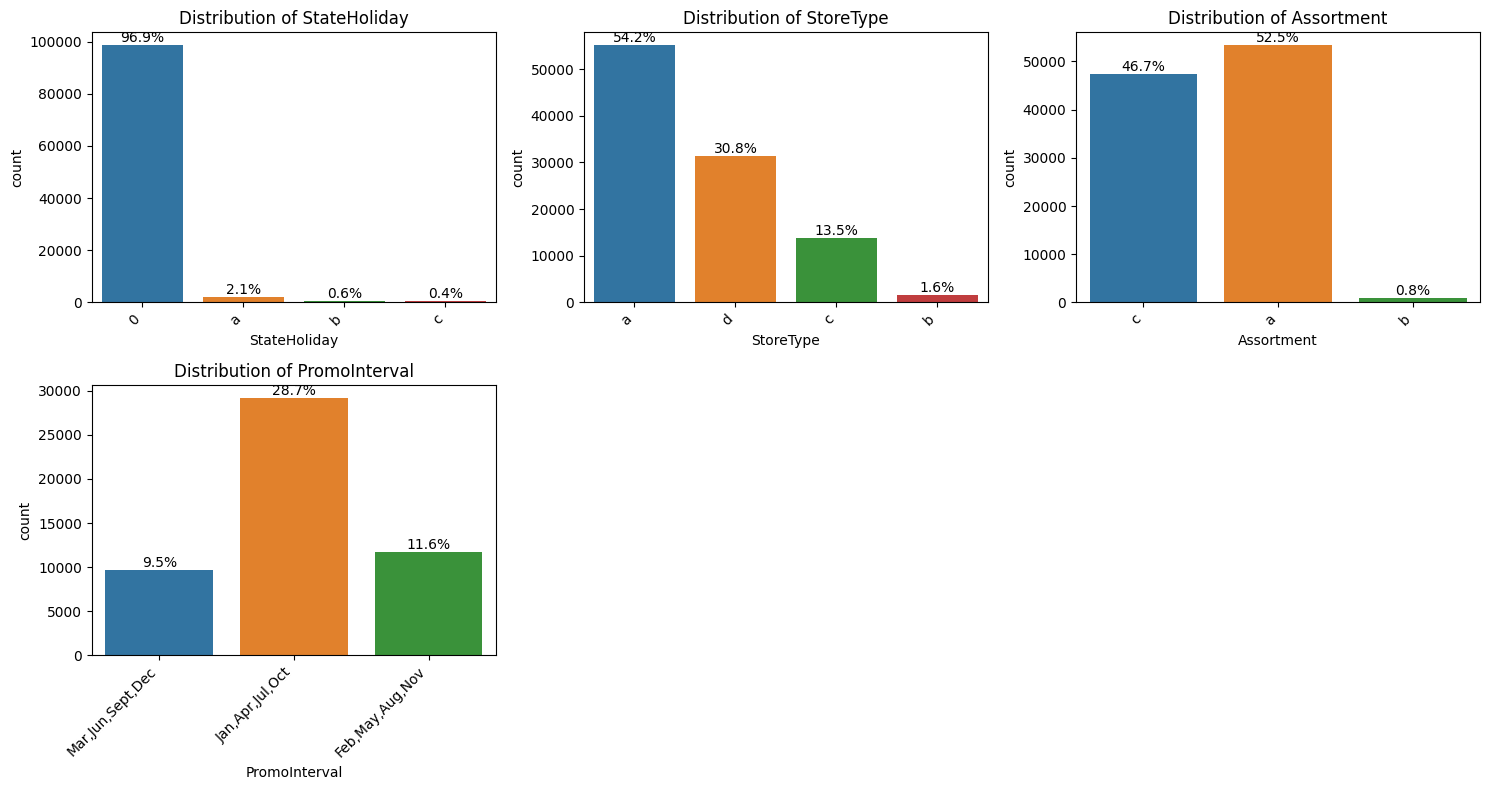

In [19]:
def plot_categorical_distribution(df):
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category'])

    # Determine the number of rows and columns for the subplots grid
    n_cols = 3
    n_rows = int(np.ceil(len(categorical_columns.columns) / n_cols))
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    # Function to annotate bars with percentage values
    def annotate_bars(ax, column):
        total = len(column)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom')

    # Plot the distribution of each categorical column
    for idx, column in enumerate(categorical_columns.columns):
        ax = axes[idx]
        sns.countplot(x=column, data=categorical_columns, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        annotate_bars(ax, categorical_columns[column])

    # Remove any unused subplots
    for idx in range(len(categorical_columns.columns), len(axes)):
        fig.delaxes(axes[idx])

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_categorical_distribution(combined_data)

Result:
- There was a high distributio of state holiday at 96%
- Store type `b` was underpresented in the data with there being more store types `a`
- Assortments `a` and `c` had a even distribution but type `b` was not well respresented
- Most of the promotions ran in `Jan, Apr, Jul, Oct`

### Plot the relationship between Categorical Features and Label

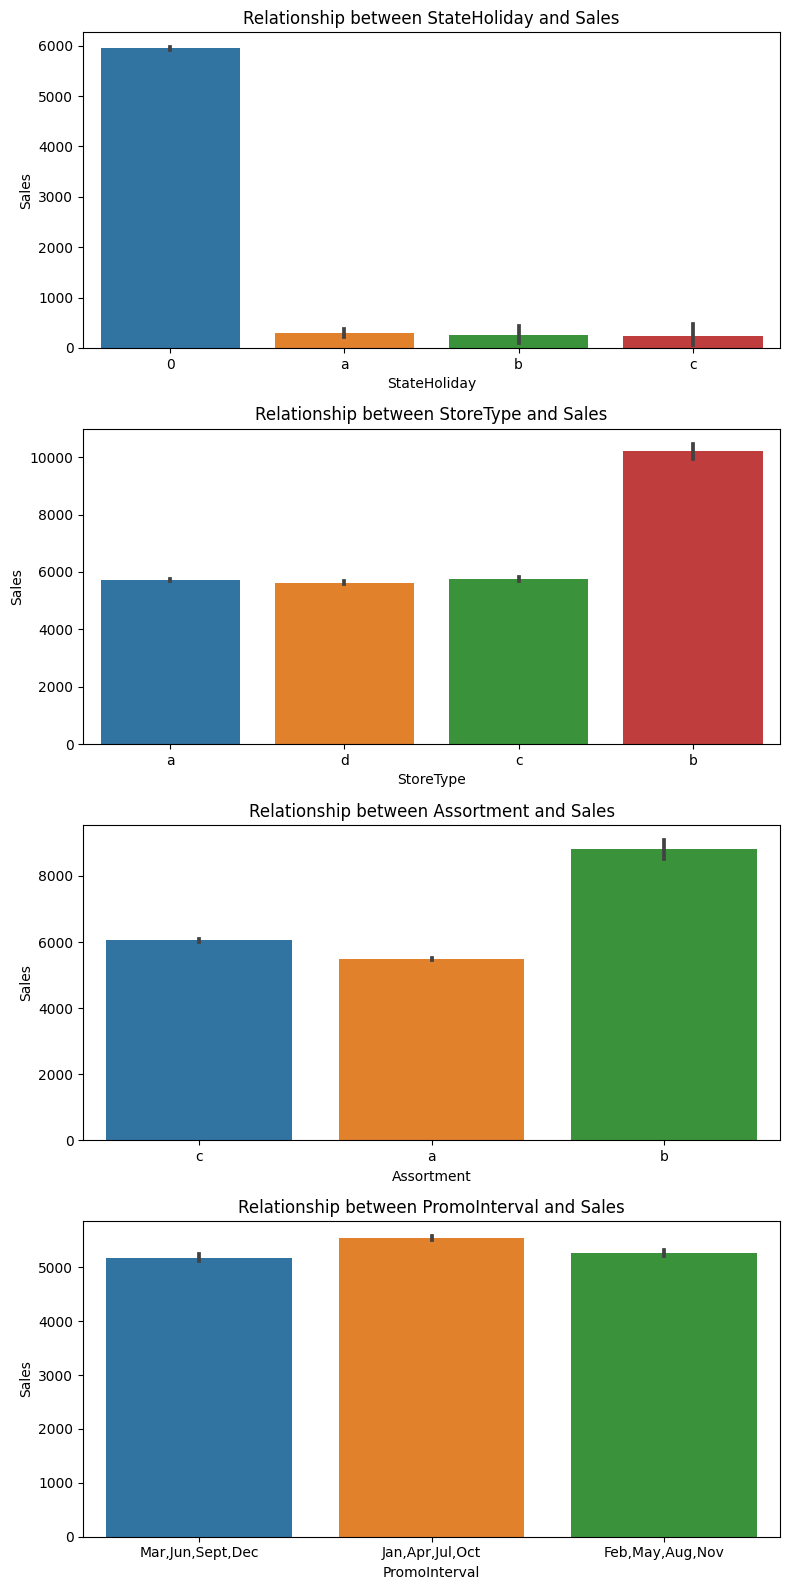

In [20]:
def plot_categorical_features(dataframe, label):
    # Identify the categorical features
    categorical_features = dataframe.select_dtypes(include=['object', 'category']).columns.tolist()

    # Create a figure and axes objects for subplots
    fig, axs = plt.subplots(nrows=len(categorical_features), figsize=(8,4*len(categorical_features)))

    # For each categorical feature, create a bar plot against the label
    for i, col in enumerate(categorical_features):
        sns.barplot(x=col, y=label, data=dataframe, ax=axs[i])

        # Set title and labels
        axs[i].set_title('Relationship between {} and {}'.format(col, label))
        axs[i].set_xlabel(col)
        axs[i].set_ylabel(label)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame and label
plot_categorical_features(combined_data, 'Sales')

Result:
- There was a high distributio of state holiday at 96% accounted for most of days with high sales
- Although type `b` was underpresented it represnted the majority of the sales
- Assortments `a` and `c` had a even distribution but type `b` was not well respresented
- Although most of the  `Jan, Apr, Jul, Oct` each promoportion interval evenly contributed to the sales

## Explore the Numerical Variables

### Describe the numerical features

In [21]:
combined_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,101721.0,559.358127,321.495649,1.0,282.0,558.0,839.0,1115.0
DayOfWeek,101721.0,4.003598,1.997798,1.0,2.0,4.0,6.0,7.0
Sales,101721.0,5771.152879,3845.344769,0.0,3739.0,5752.0,7847.0,41551.0
Customers,101721.0,633.031842,465.518310,0.0,406.0,609.0,836.0,7388.0
Open,101721.0,0.829494,0.376078,0.0,1.0,1.0,1.0,1.0
Promo,101721.0,0.381583,0.485777,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,101721.0,0.177810,0.382355,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,101458.0,5466.068028,7745.482625,20.0,720.0,2330.0,6900.0,75860.0
CompetitionOpenSinceMonth,69385.0,7.196253,3.212381,1.0,4.0,7.0,10.0,12.0
CompetitionOpenSinceYear,69385.0,2008.736672,5.863185,1900.0,2006.0,2010.0,2013.0,2015.0


Result:
- There are 1115 stores with a  standard devitiation of 464 for customers and standard devitiaion of 3849 for daily sales

### Explore the relationship between DayOfWeek, DayOfMonth and MonthOfYear to sales

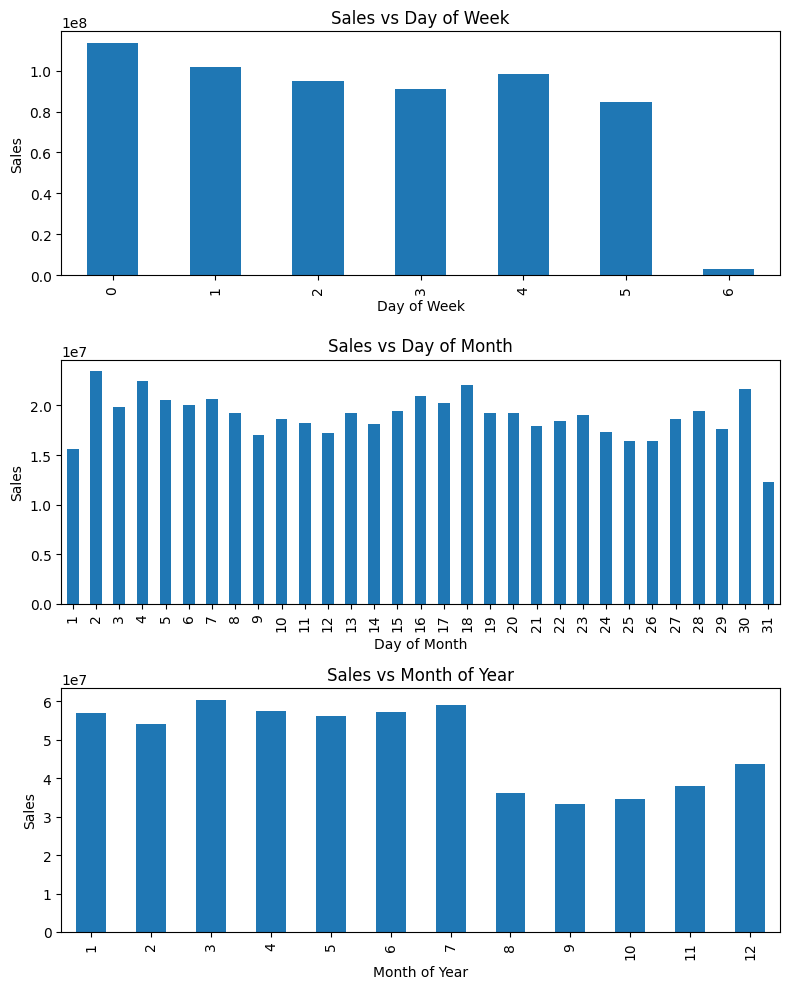

In [22]:
def plot_sales(dataframe, date_col='Date', sales_col='Sales'):
    # Ensure the date column is in datetime format
    dataframe[date_col] = pd.to_datetime(dataframe[date_col])

    # Extract day of week, day of month, month of year from the date column
    dataframe['DayOfWeek'] = dataframe[date_col].dt.dayofweek
    dataframe['DayOfMonth'] = dataframe[date_col].dt.day
    dataframe['MonthOfYear'] = dataframe[date_col].dt.month

    # Create subplots
    fig, axs = plt.subplots(3, figsize=(8, 10))

    # Sales vs Day of Week
    dataframe.groupby('DayOfWeek')[sales_col].sum().plot(kind='bar', ax=axs[0])
    axs[0].set_title('Sales vs Day of Week')
    axs[0].set_xlabel('Day of Week')
    axs[0].set_ylabel('Sales')

    # Sales vs Day of Month
    dataframe.groupby('DayOfMonth')[sales_col].sum().plot(kind='bar', ax=axs[1])
    axs[1].set_title('Sales vs Day of Month')
    axs[1].set_xlabel('Day of Month')
    axs[1].set_ylabel('Sales')

    # Sales vs Month of Year
    dataframe.groupby('MonthOfYear')[sales_col].sum().plot(kind='bar', ax=axs[2])
    axs[2].set_title('Sales vs Month of Year')
    axs[2].set_xlabel('Month of Year')
    axs[2].set_ylabel('Sales')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_sales(combined_data)

Result:
- Few sales occured on Sunday than in any other day of the week.
- Most Sales are done in the beginning of the month with end of the month being the lowest.
- Sales are relatively are lower at the end of year.

### Relation between Continous numerical Features and Labels

In [23]:
# def plot_numerical_features(dataframe, label):
#     # Identify the numerical features
#     numerical_features = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()

#     # Create a figure and axes objects for subplots
#     fig, axs = plt.subplots(nrows=len(numerical_features), figsize=(10,6*len(numerical_features)))

#     # For each numerical feature, create a boxplot against the label
#     for i, col in enumerate(numerical_features):
#         if col != label:  # We skip the label
#             sns.boxplot(x=label, y=col, data=dataframe, ax=axs[i])

#             # Set title and labels
#             axs[i].set_title('Relationship between {} and {}'.format(col, label))
#             axs[i].set_xlabel(label)
#             axs[i].set_ylabel(col)

#     # Display the plot
#     plt.tight_layout()
#     plt.show()

# # Call the function with your DataFrame and label
# plot_numerical_features(combined_data, 'Sales')

### Find Outliers in numerical features

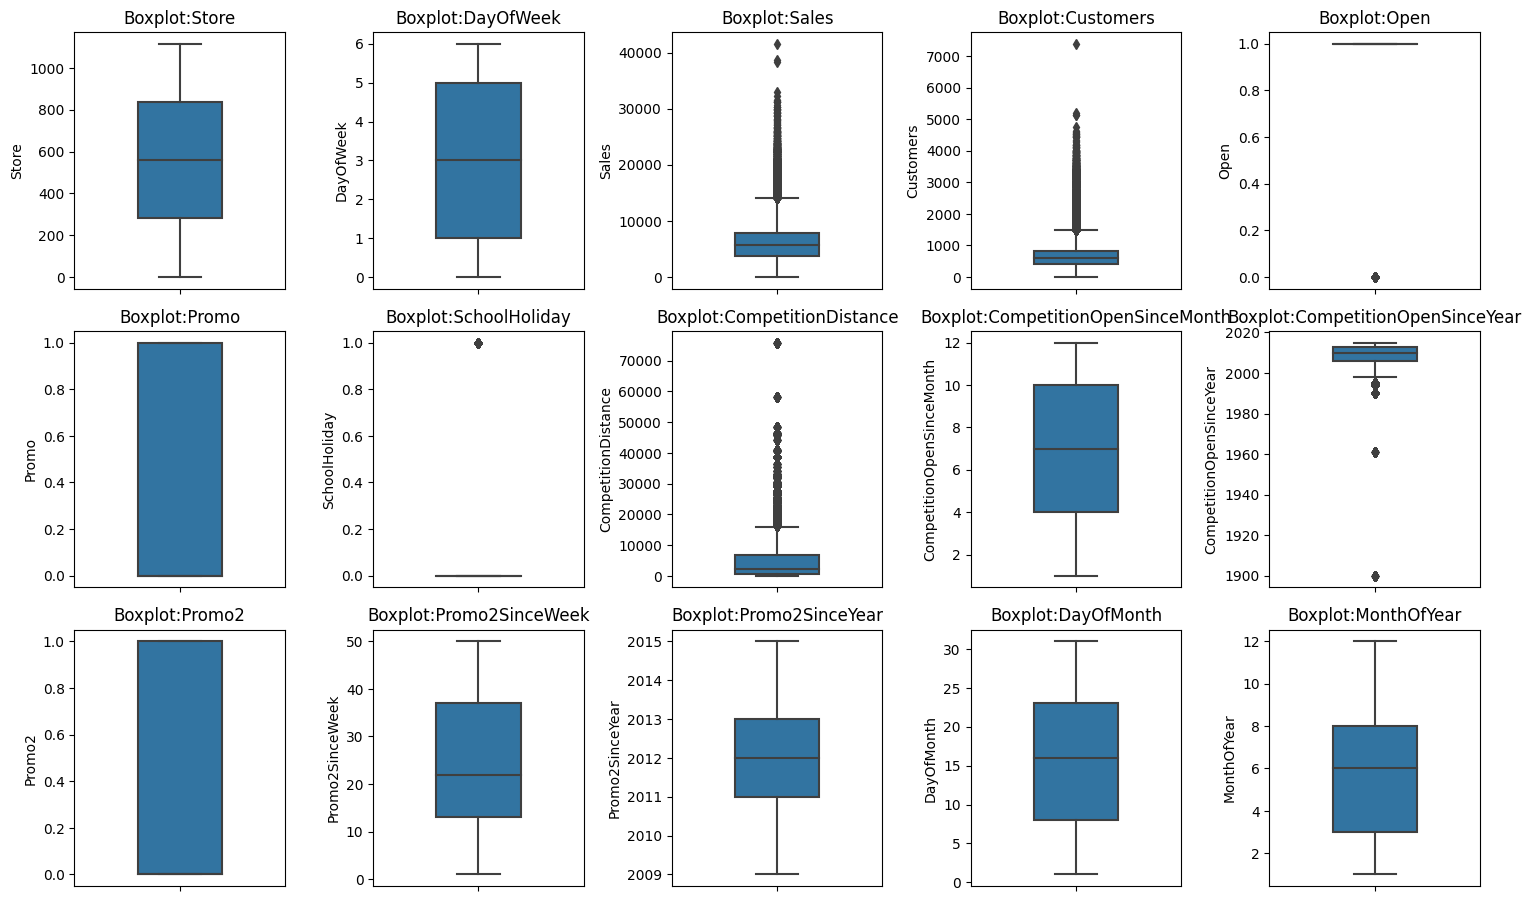

In [24]:
def plot_outliers_with_boxplot(df):
    # Select columns with numeric data types (float and integer)
    numeric_columns = df.select_dtypes(include=['number'])

    # Set up the figure and axis for subplots
    n_rows = (len(numeric_columns.columns) + 1) // 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=5, figsize=(15, 3 * n_rows))
    axes = axes.flatten()  # Flatten axes to make it easier to iterate

    # Plot the boxplot for each numerical column
    for idx, column in enumerate(numeric_columns.columns):
        sns.boxplot(data=df, y=column, ax=axes[idx], width=0.4)
        axes[idx].set_title(f'Boxplot:{column}')

    # Remove empty subplots
    for idx in range(len(numeric_columns.columns), len(axes)):
        fig.delaxes(axes[idx])

    # Display the plot
    plt.tight_layout()
    plt.show()

# Plot the boxplots to show outliers in numerical features
plot_outliers_with_boxplot(combined_data)

Result:
- `['Sales', 'Customers', 'CompetitionDistance', 'CompetitionOpenSinceYear']` appear have outliers
- `['CompetitionDistance']` can outliers can be handled through binining
- `['CompetitionOpenSinceYear']` is in the normal range, since stores could have been opened in the early 1900s


### Check if the target distribution

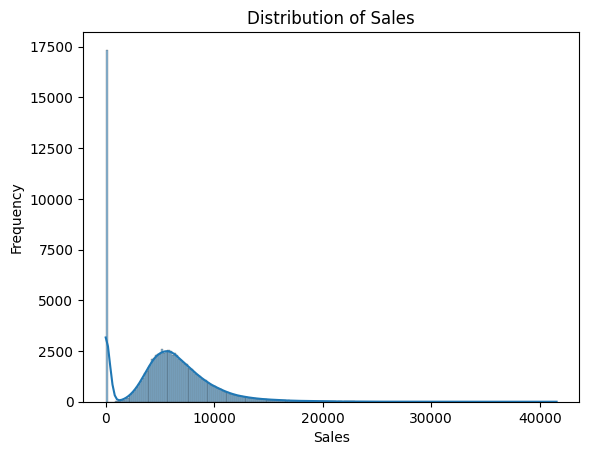

In [25]:
def plot_label_distribution(label_data):
    sns.histplot(label_data, kde=True)
    plt.title('Distribution of Sales')
    plt.xlabel('Sales')
    plt.ylabel('Frequency')
    plt.show()

# Call the function with your target label data
plot_label_distribution(combined_data['Sales'])


Result:
- Sales has a normal distribution. Although there is a large number of 0 entries, probably due to when the store was closed. This will be handled when evaluating the outliers

### Review the effect of sales promotion on sales

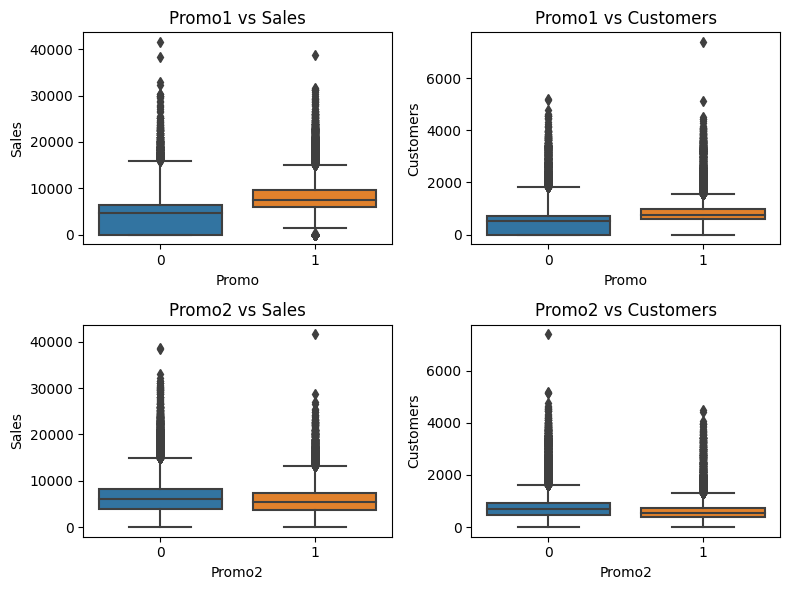

In [26]:
def plot_promos_effect(dataframe, promo1_col='Promo', promo2_col='Promo2', sales_col='Sales', customers_col='Customers'):
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))

    # Promo1 vs Sales
    sns.boxplot(x=promo1_col, y=sales_col, data=dataframe, ax=axs[0, 0])
    axs[0, 0].set_title('Promo1 vs Sales')

    # Promo1 vs Customers
    sns.boxplot(x=promo1_col, y=customers_col, data=dataframe, ax=axs[0, 1])
    axs[0, 1].set_title('Promo1 vs Customers')

    # Promo2 vs Sales
    sns.boxplot(x=promo2_col, y=sales_col, data=dataframe, ax=axs[1, 0])
    axs[1, 0].set_title('Promo2 vs Sales')

    # Promo2 vs Customers
    sns.boxplot(x=promo2_col, y=customers_col, data=dataframe, ax=axs[1, 1])
    axs[1, 1].set_title('Promo2 vs Customers')

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_promos_effect(combined_data)

Result:  

- Promo1 was more successful than Promo2 in driving customers and sales. Promp2 seems to have had a slight negative effect on customers and sales

### Review the effect of store type on sales

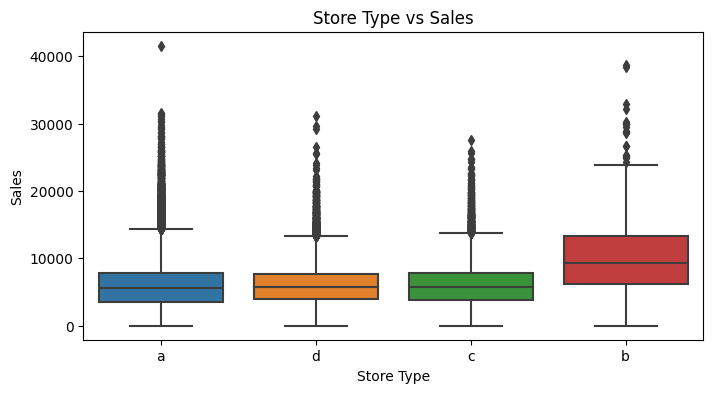

In [27]:
def plot_storetype_sales(dataframe, storetype_col='StoreType', sales_col='Sales'):
    # Create a boxplot of Sales vs StoreType
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=storetype_col, y=sales_col, data=dataframe)

    # Set title and labels
    plt.title('Store Type vs Sales')
    plt.xlabel('Store Type')
    plt.ylabel('Sales')

    # Display the plot
    plt.show()

# Call the function with your DataFrame
plot_storetype_sales(combined_data)

Result:
- Store type `b` outperformed all other stores in sales

### Review the which stores ran promotions and their effect on sales

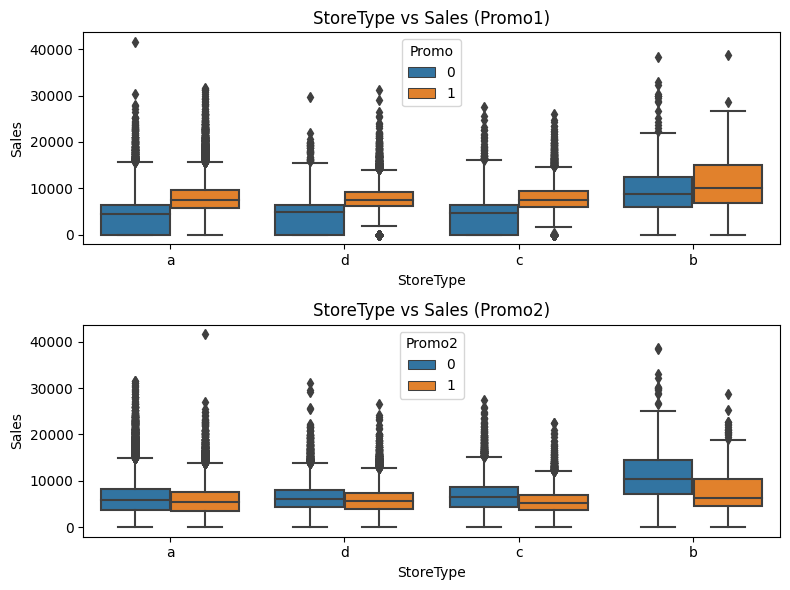

In [28]:
def plot_storetype_promos(dataframe, storetype_col='StoreType',
                                              promo1_col='Promo', promo2_col='Promo2',
                                              sales_col='Sales'):


    # Create subplots
    fig, axs = plt.subplots(2, figsize=(8, 6))

    # StoreType vs Sales with hue as Promo
    sns.boxplot(x=storetype_col, y=sales_col, hue=promo1_col, data=dataframe, ax=axs[0])
    axs[0].set_title('StoreType vs Sales (Promo1)')

    # StoreType vs Sales with hue as Promo2
    sns.boxplot(x=storetype_col, y=sales_col, hue=promo2_col, data=dataframe, ax=axs[1])
    axs[1].set_title('StoreType vs Sales (Promo2)')


    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_storetype_promos(combined_data)

Result:
- Store type b ran more `promo` and fewer `promo2`s
- We might choose to exclude either store type b or `promo`, `promo2` in our dataset

### Review the relationship between store type and distance from competition

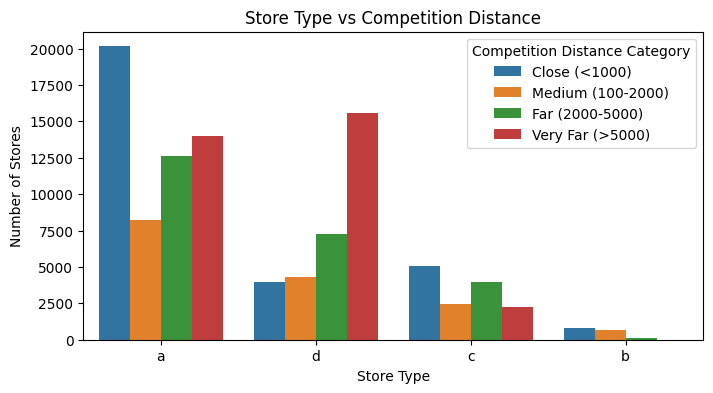

In [29]:
def plot_storetype_competition(dataframe, storetype_col='StoreType', competition_distance_col='CompetitionDistance'):
    # Define bins edges
    bins = [0, 1000, 2000, 5000, np.inf]
    # Define bins labels
    labels = ['Close (<1000)', 'Medium (100-2000)', 'Far (2000-5000)', 'Very Far (>5000)']


    # Create a new column 'CompetitionDistanceCategory' by binning 'CompetitionDistance' column
    dataframe['CompetitionDistanceCategory'] = pd.cut(dataframe[competition_distance_col], bins, labels=labels)

    # Create a bar plot of StoreType vs CompetitionDistanceCategory
    plt.figure(figsize=(8, 4))
    sns.countplot(x=storetype_col, hue='CompetitionDistanceCategory', data=dataframe)

    # Set title and labels
    plt.title('Store Type vs Competition Distance')
    plt.xlabel('Store Type')
    plt.ylabel('Number of Stores')
    plt.legend(title='Competition Distance Category')

    # Display the plot
    plt.show()

# Call the function with your DataFrame
plot_storetype_competition(combined_data)

Result:
- Store type `b` is located close to the competition with majority of the stores less than 2000 meters of their competition, most likely where there is a high volume of foot traffic

### Review the relationship between sales and distance from competition

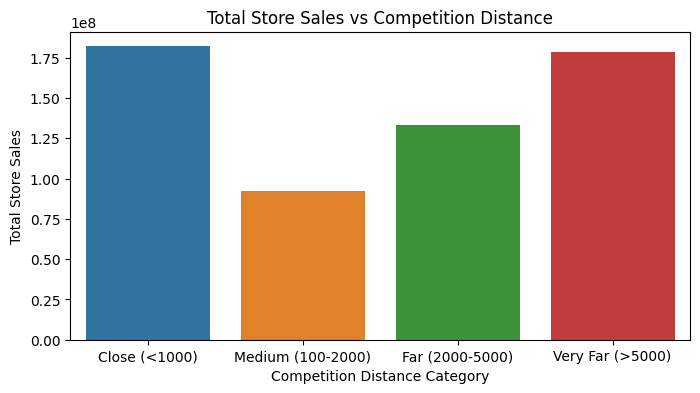

In [30]:
def plot_sales_competition(dataframe, sales_col='Sales', competition_distance_col='CompetitionDistance'):
    # Define bins edges
    bins = [0, 1000, 2000, 5000, np.inf]
    # Define bins labels
    labels = ['Close (<1000)', 'Medium (100-2000)', 'Far (2000-5000)', 'Very Far (>5000)']

    # Create a new column 'CompetitionDistanceCategory' by binning 'CompetitionDistance' column
    dataframe['CompetitionDistanceCategory'] = pd.cut(dataframe[competition_distance_col], bins, labels=labels)

    # Group by 'CompetitionDistanceCategory' and calculate total sales
    group_df = dataframe.groupby('CompetitionDistanceCategory')[sales_col].sum().reset_index()

    # Create a bar plot of Total Sales vs CompetitionDistanceCategory
    plt.figure(figsize=(8, 4))
    sns.barplot(x='CompetitionDistanceCategory', y=sales_col, data=group_df)

    # Set title and labels
    plt.title('Total Store Sales vs Competition Distance')
    plt.xlabel('Competition Distance Category')
    plt.ylabel('Total Store Sales')

    # Display the plot
    plt.show()

# Call the function with your DataFrame
plot_sales_competition(combined_data)

Result:
- Distance to a competitive store does affect the total sales, with stores either very close <1000 m or very far from competition <5000m doing much better in sales

In [31]:
combined_data.drop(['CompetitionDistanceCategory'], axis=1, inplace=True)

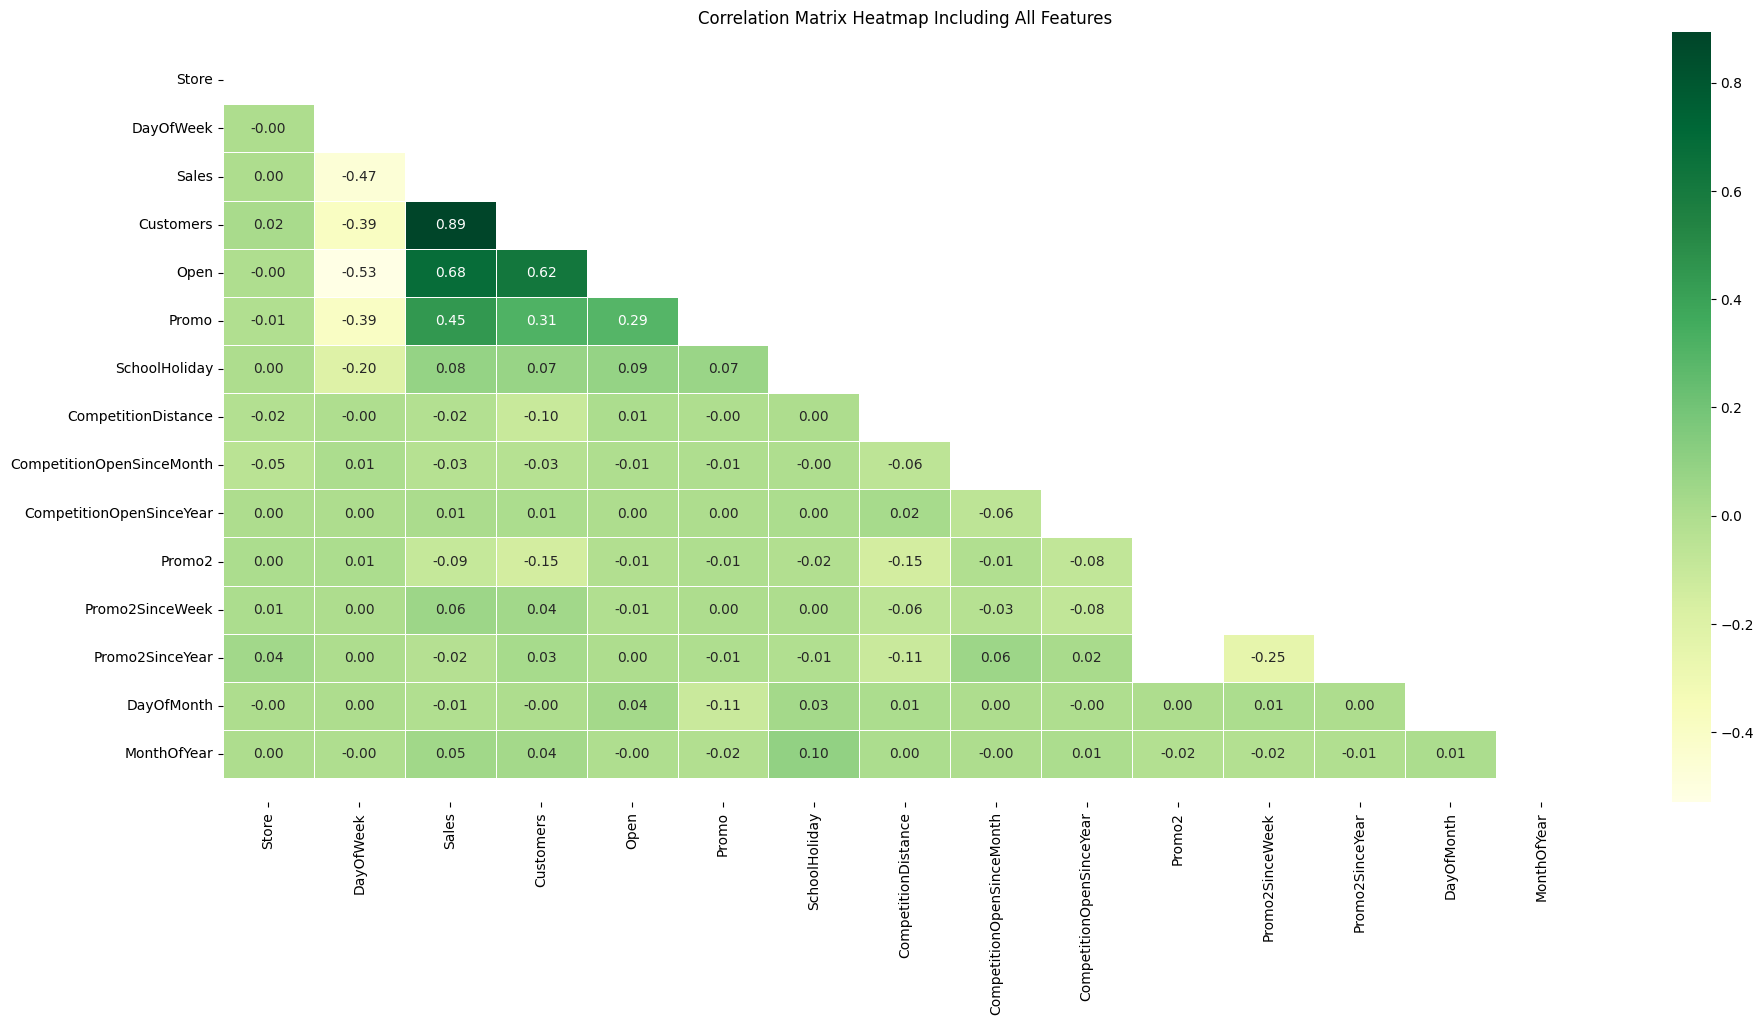

In [32]:
#@title Correlation Heatmap After Merge
corr_matrix = combined_data.corr(numeric_only=True)

mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(corr_matrix)] = True

# Correlation Matrix Heatmap including all features
fig, ax = plt.subplots(figsize=(22,10))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGn")
#ax = sns.heatmap(corr_matrix, mask=mask, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title("Correlation Matrix Heatmap Including All Features")

# save heatmap as .png file
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

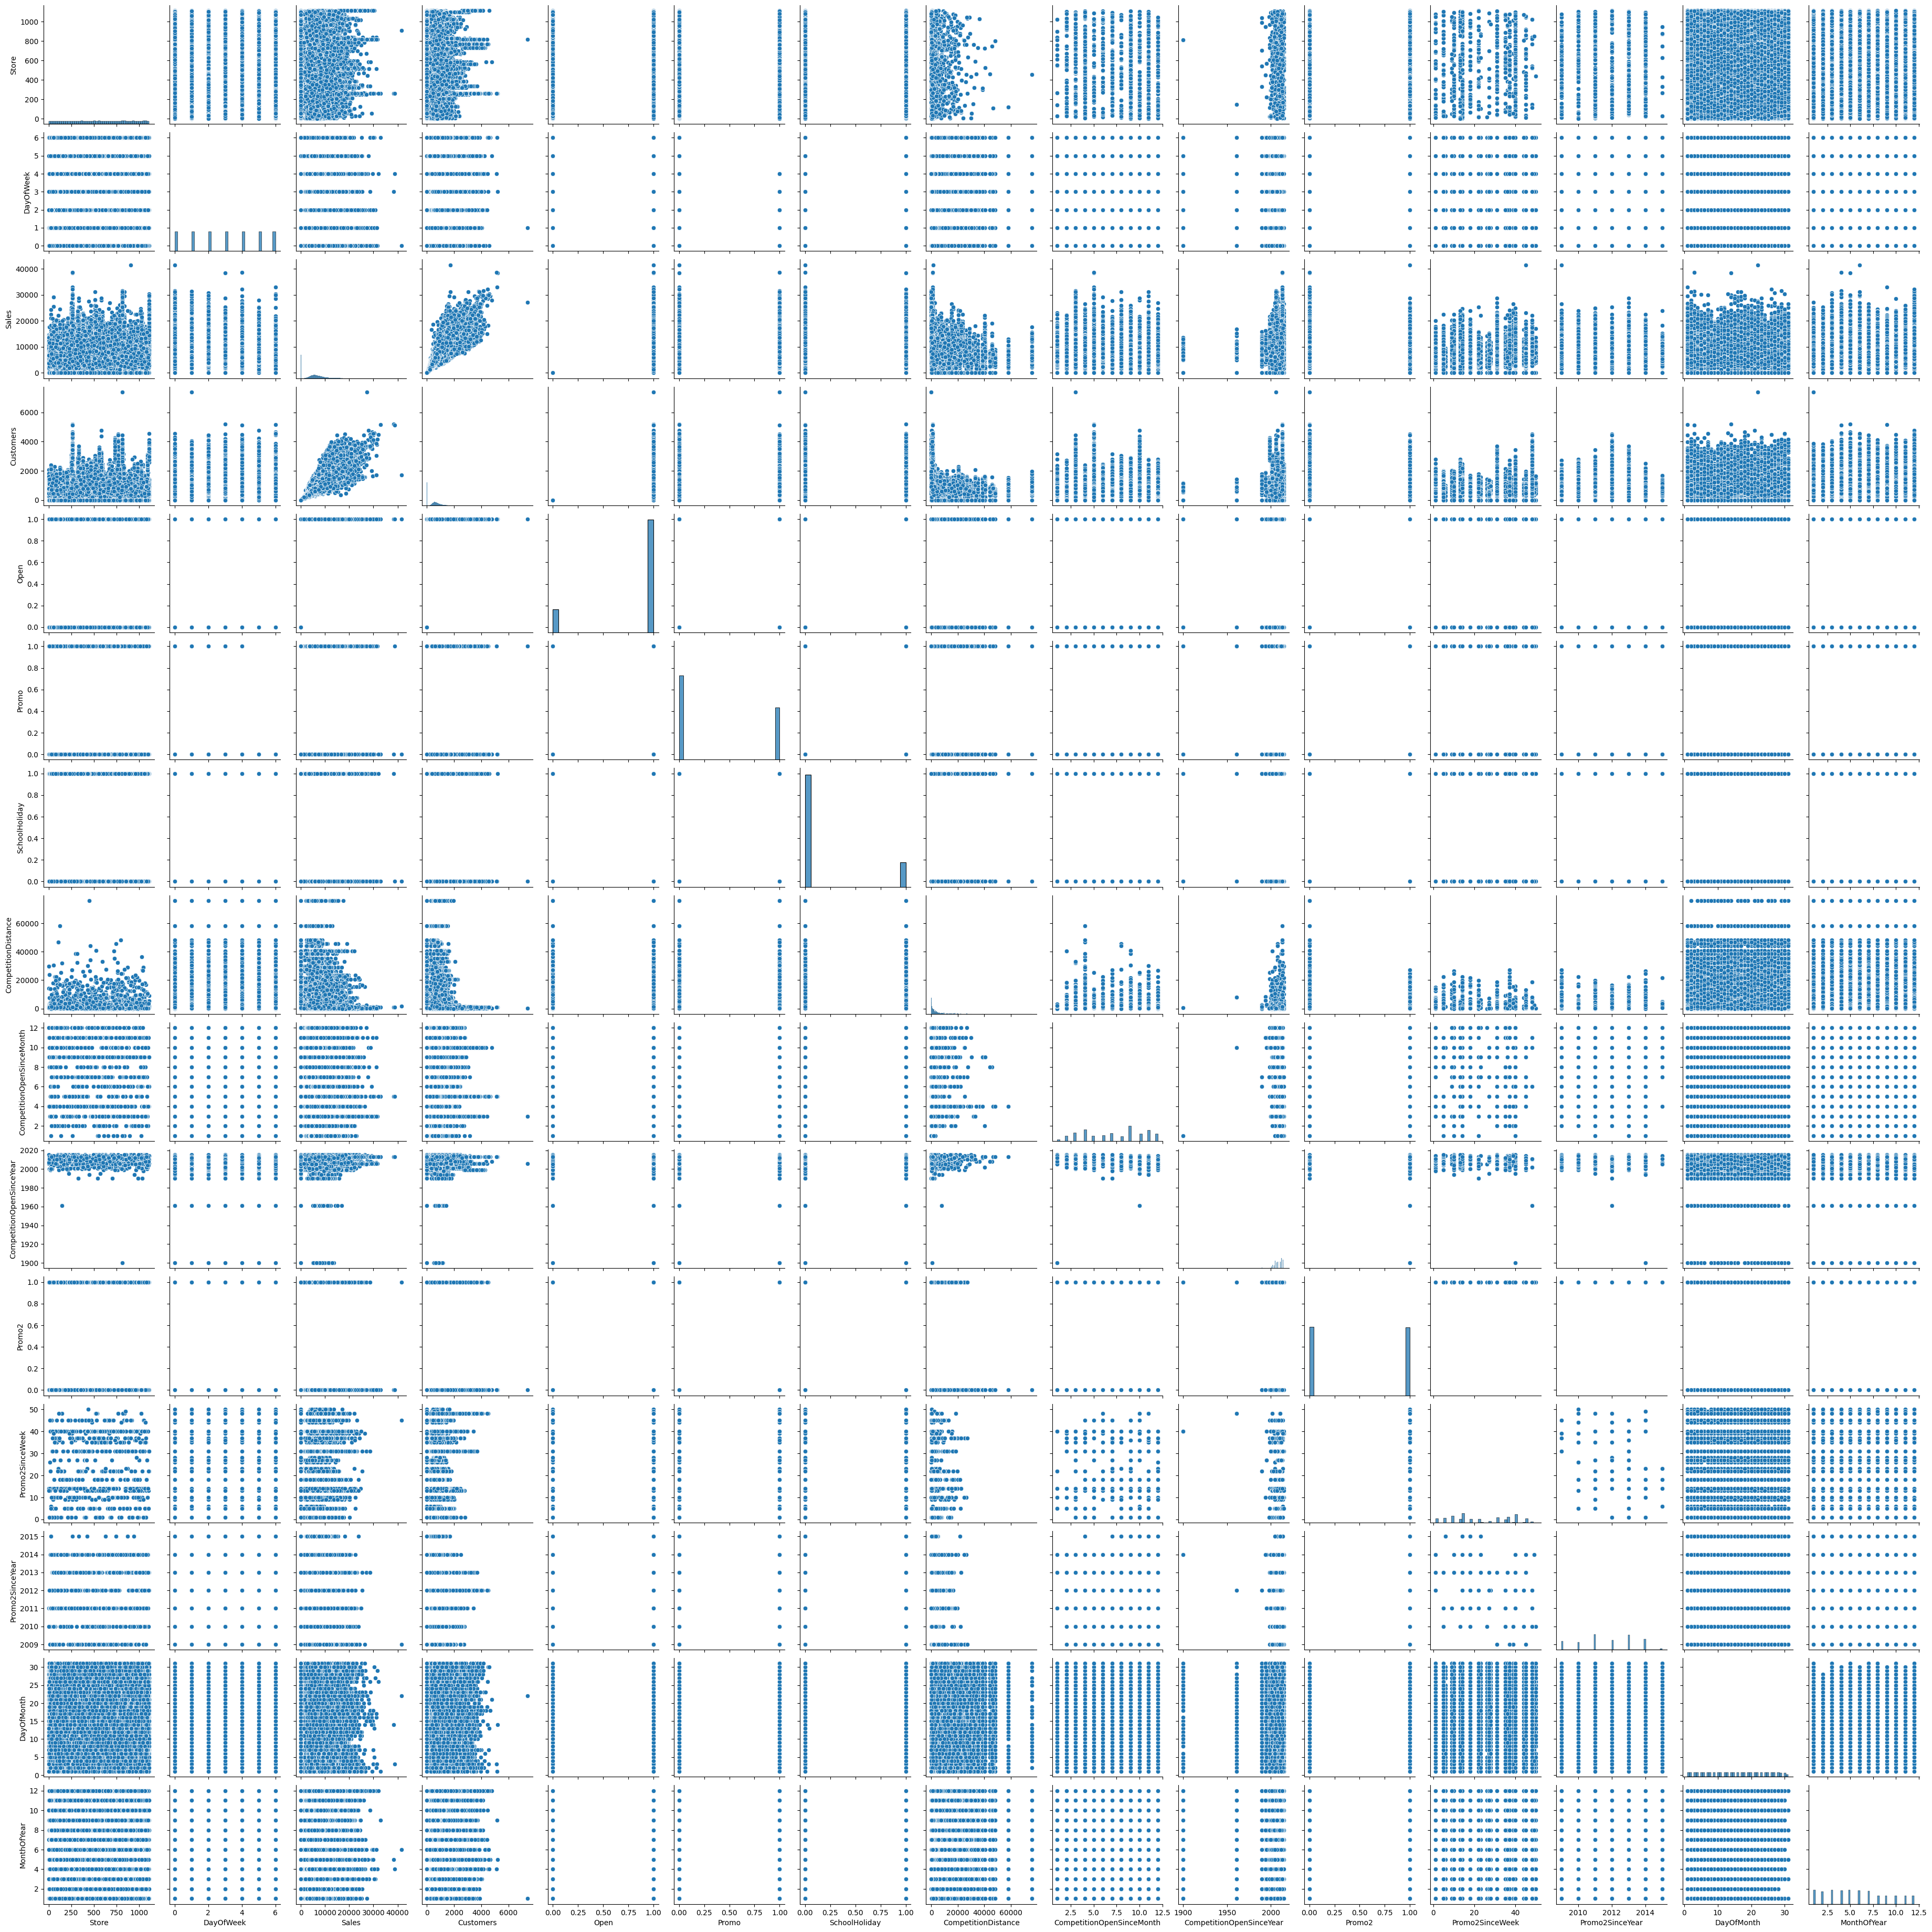

In [33]:
#@title Pairplot of Combined Data
sns.pairplot(combined_data)
plt.show()

# Feature Engineering

Feature engineering is an essential step in the machine learning process, where raw data is transformed into useful features that can improve the performance of a model. Below is a list feature engineering techniques that we explored

##### Handling missing values:
- Impute missing values using mean, median, or mode.
- Use interpolation methods for time-series data.
- Drop rows or columns with missing values.

##### Encoding categorical variables:
- One-hot encoding.
- Label encoding.
- Ordinal encoding.
- Target-based encoding.

##### Handling numerical features:
- Scaling: Min-Max scaling
- Binning: Discretize continuous features into bins.
- Polynomial features: Generate new features by combining existing features through mathematical operations (e.g., addition, multiplication, exponentiation).

##### Handling date and time features:
- Extract components such as year, month, day, day of the week, and time of the day.
- Create cyclical features to capture patterns in time-series data.

##### Feature selection:
- Filter methods: Select features based on correlation, mutual information, or variance.
- Embedded methods: Utilize models with built-in feature selection, such as LASSO, Ridge Regression, or Random Forests.

##### Feature interactions:
- Identify and create new features based on interactions between existing features that can improve model performance.

## Handling missing values

From [Section 4.1.3 Check for Missing values](#Check-for-Missing-values)

`['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval']`

have missing values

### Missing values `['Promo2SinceWeek','Promo2SinceYear','PromoInterval']`

In [34]:
print(combined_data[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval']].isna().sum())

CompetitionDistance            263
CompetitionOpenSinceMonth    32336
CompetitionOpenSinceYear     32336
Promo2SinceWeek              51105
Promo2SinceYear              51105
PromoInterval                51105
dtype: int64


Stores not running `promo2` corelate with values `Promo2SinceWeek`, `Promo2SinceYear` and `PromoInterval`

In [35]:
combined_data[combined_data['Promo2'] == 0].shape[0]

51105

Treat NaN for `PromoInterval` with new value Unknown,  `Promo2SinceYear` and `Promo2SinceWeek` with todays year ad week respectively

In [36]:
# Replace NaN values with 0 in the specified columns
combined_data['Promo2SinceWeek'] = combined_data['Promo2SinceWeek'].fillna(dt.datetime.now().isocalendar()[1])
combined_data['Promo2SinceYear'] = combined_data['Promo2SinceYear'].fillna(dt.datetime.now().year)
combined_data['PromoInterval'] = combined_data['PromoInterval'].fillna("PromoUnknown")

# Define a dictionary to map the old values to the new ones
replace_dict = {'Jan,Apr,Jul,Oct': 'PromoInterval1',
                'Feb,May,Aug,Nov': 'PromoInterval2',
                'Mar,Jun,Sept,Dec': 'PromoInterval3'}

# Use the replace function to change the values
combined_data['PromoInterval'] = combined_data['PromoInterval'].replace(replace_dict)


Check for missing values

In [37]:
print(combined_data[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval']].isna().sum())

CompetitionDistance            263
CompetitionOpenSinceMonth    32336
CompetitionOpenSinceYear     32336
Promo2SinceWeek                  0
Promo2SinceYear                  0
PromoInterval                    0
dtype: int64


### Missing values `['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']`

**CompetitionDistance** has a very strong [corellation with sales](#Review-the-relationship-between-store-type-and-distance-from-competition) and we treat CompetitionDistance missing values by replacing them with the mean for each store type

In [38]:
storeTypeA = combined_data.loc[(combined_data['StoreType'] == 'a'), 'CompetitionDistance'].mean()
storeTypeB = combined_data.loc[(combined_data['StoreType'] == 'b'), 'CompetitionDistance'].mean()
storeTypeC = combined_data.loc[(combined_data['StoreType'] == 'c'), 'CompetitionDistance'].mean()
storeTypeD = combined_data.loc[(combined_data['StoreType'] == 'd'), 'CompetitionDistance'].mean()


combined_data.loc[combined_data['StoreType'] == 'a'] = combined_data.loc[combined_data['StoreType'] == 'a'].fillna(value={"CompetitionDistance" : storeTypeA})
combined_data.loc[combined_data['StoreType'] == 'b'] = combined_data.loc[combined_data['StoreType'] == 'b'].fillna(value={"CompetitionDistance" : storeTypeB})
combined_data.loc[combined_data['StoreType'] == 'c'] = combined_data.loc[combined_data['StoreType'] == 'c'].fillna(value={"CompetitionDistance" : storeTypeC})
combined_data.loc[combined_data['StoreType'] == 'd'] = combined_data.loc[combined_data['StoreType'] == 'd'].fillna(value={"CompetitionDistance" : storeTypeD})

**CompetitionOpenSinceMonth** and **CompetitionOpenSinceYear** are treated by replacing NaNs with current Month and year respectively

In [39]:
combined_data['CompetitionOpenSinceMonth'] = combined_data['CompetitionOpenSinceMonth'].fillna(dt.datetime.now().month)
combined_data['CompetitionOpenSinceYear'] = combined_data['Promo2SinceWeek'].fillna(dt.datetime.now().year)

Check for missing values

In [40]:
print(combined_data[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval']].isna().sum())

CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


## Outliers

From [Section 4.3.4 Find Outliers in Numerical Variables](#Find-Outliers-in-numerical-features)

`['Sales', 'Customers', 'CompetitionDistance']` have outliers.

**CompetitionDistance** outliers will be handled through bining

### `['Sales', 'Customers',]` outliers

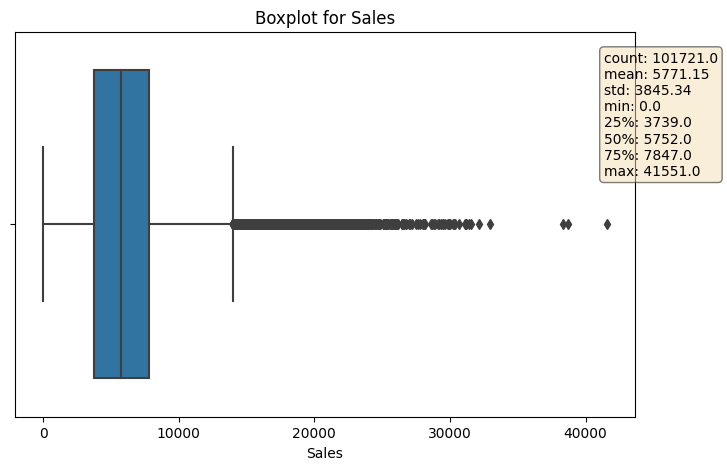

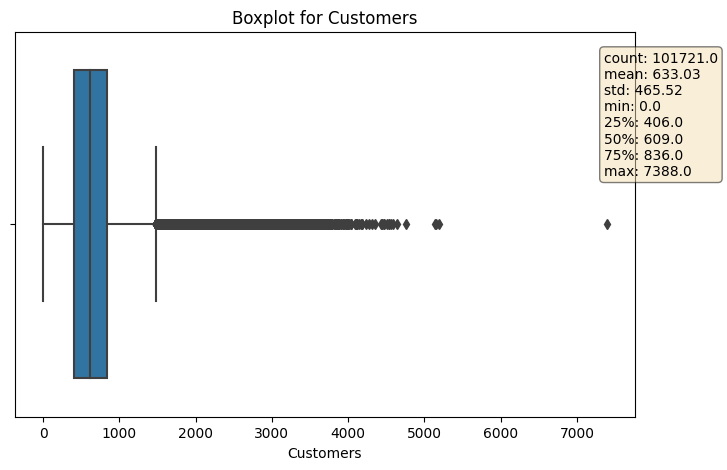

In [41]:
def draw_boxplot(data, columns):
    for column in columns:
        plt.figure(figsize=(8,5))

        # Create boxplot
        box_plot = sns.boxplot(x=data[column])

        # Get statistics
        stats = data[column].describe().round(2)

        # Add statistics to the plot
        textstr = '\n'.join([f'{key}: {val}' for key, val in stats.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        box_plot.text(0.95, 0.95, textstr, transform=box_plot.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

        # Set plot title
        plt.title(f'Boxplot for {column}')
        plt.show()

draw_boxplot(combined_data, ['Sales', 'Customers'])

Result:
- There are no stores with customers or sales below 0
- Replace the values above the upper 1.5xIQR with the upper outlier value

In [42]:
def calculate_upper_outlier_value(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    upper_outlier_value = Q3 + 1.5 * IQR

    return upper_outlier_value


upper_sales_outlier_value = calculate_upper_outlier_value(combined_data, 'Sales')
upper_customers_outlier_value = calculate_upper_outlier_value(combined_data, 'Customers')

print("Upper Outlier Value for Sales: ", upper_sales_outlier_value)
print("Upper Outlier Value for Customers: ", upper_customers_outlier_value)

Upper Outlier Value for Sales:  14009.0
Upper Outlier Value for Customers:  1481.0


In [43]:
def replace_upper_outliers(dataframe, column):
    upper_outlier_value = calculate_upper_outlier_value(dataframe, column)
    dataframe[column] = dataframe[column].apply(lambda x: upper_outlier_value if x > upper_outlier_value else x)
    return dataframe

combined_data = replace_upper_outliers(combined_data, 'Sales')
combined_data = replace_upper_outliers(combined_data, 'Customers')

Check for outliers

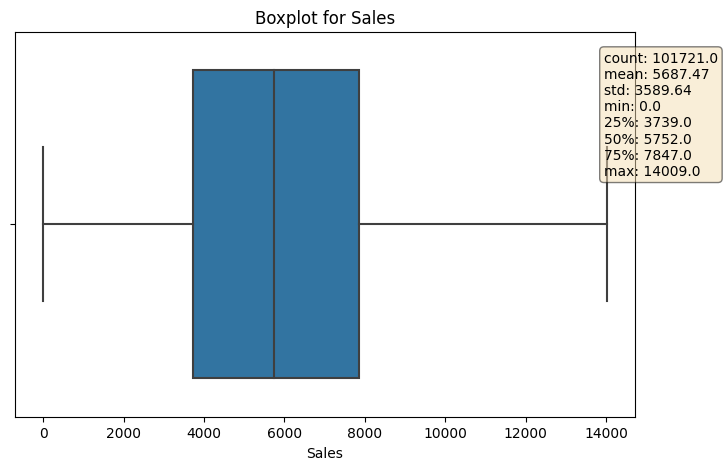

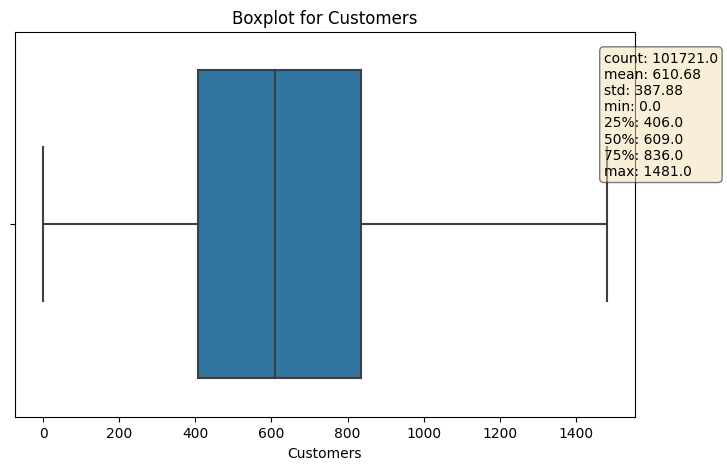

In [44]:
draw_boxplot(combined_data, ['Sales', 'Customers'])

### Drop the rows when the stores are closed then drop the `open` column

Calculate the total sales for the stores that were closed `Open=0`

In [45]:
def sum_sales_closed_stores(data):
    closed_stores = data[data['Open'] == 0]
    total_sales = closed_stores['Sales'].sum()
    return total_sales

# Use the function
total_sales_closed = sum_sales_closed_stores(combined_data)
print(f'Total sales for stores that were closed is {total_sales_closed}.')

Total sales for stores that were closed is 0.0.


Drop the Rows of Date where Stores where closed

In [46]:
def drop_closed_stores(data):
    # Select only the rows where 'Open' is not equal to 0
    open_stores = data[data['Open'] != 0]
    return open_stores

# Use the function
combined_data = drop_closed_stores(combined_data)

In [47]:
combined_data['Open'].value_counts()

1    84377
Name: Open, dtype: int64

In [48]:
combined_data.drop(columns=["Open"], inplace=True)

<ipython-input-48-2cc5ad16418f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data.drop(columns=["Open"], inplace=True)


## Encoding

### Binning of the CompetitionDistance

In [49]:
def bin_competition_distance(dataframe):
    # Define the bins and labels
    bins = [0, 1000, 2000, 5000, np.inf]
    labels = ['Close', 'Medium', 'Far', 'Very Far']

    # Create a new column with the binned distances
    dataframe['CompetitionDistance'] = pd.cut(dataframe['CompetitionDistance'], bins=bins, labels=labels)

    return dataframe

# Apply the function to your DataFrame
combined_data = bin_competition_distance(combined_data)

<ipython-input-49-3538e6cca059>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['CompetitionDistance'] = pd.cut(dataframe['CompetitionDistance'], bins=bins, labels=labels)


In [50]:
combined_data.CompetitionDistance

923026         Far
731180       Close
790350    Very Far
252134    Very Far
666826      Medium
            ...   
270985       Close
135808       Close
537730       Close
423639    Very Far
256043      Medium
Name: CompetitionDistance, Length: 84377, dtype: category
Categories (4, object): ['Close' < 'Medium' < 'Far' < 'Very Far']

### One hot encoding - categorical Features

This is a method of turning categorical data into binary (0 or 1) sequences to ensure the machine learning model doesn't attribute an order to the categories where none exists. This method is useful when the categorical variable is nominal (i.e., when there is no order or priority in the categories). We use One Hot encoding to encode the [nominal categorical features identified in section 4.2.1](#List-the-Categorical-features)

In [51]:
print_categorical_values(combined_data)

Categorical Column: StateHoliday
Unique Values: ['0' 'a' 'b' 'c']

Categorical Column: StoreType
Unique Values: ['a' 'd' 'c' 'b']

Categorical Column: Assortment
Unique Values: ['a' 'c' 'b']

Categorical Column: CompetitionDistance
Unique Values: ['Far', 'Close', 'Very Far', 'Medium']
Categories (4, object): ['Close' < 'Medium' < 'Far' < 'Very Far']

Categorical Column: PromoInterval
Unique Values: ['PromoUnknown' 'PromoInterval3' 'PromoInterval1' 'PromoInterval2']



In [52]:
# fucntion to One Hot Encoding
def encode(data, col):
    return pd.concat([data, pd.get_dummies(col, prefix=col.name)], axis=1)

# One Hot encoding of 3 variable
combined_data = encode(combined_data, combined_data.StateHoliday)
combined_data = encode(combined_data, combined_data.StoreType)
combined_data = encode(combined_data, combined_data.Assortment)
combined_data = encode(combined_data, combined_data.PromoInterval)
combined_data = encode(combined_data, combined_data.CompetitionDistance)

# Drop tranfromed features
combined_data.drop(['StateHoliday', 'StoreType', 'Assortment','PromoInterval','CompetitionDistance'], axis=1, inplace=True)

In [53]:
combined_data.tail(5)

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,...,Assortment_b,Assortment_c,PromoInterval_PromoInterval1,PromoInterval_PromoInterval2,PromoInterval_PromoInterval3,PromoInterval_PromoUnknown,CompetitionDistance_Close,CompetitionDistance_Medium,CompetitionDistance_Far,CompetitionDistance_Very Far
270985,11,0,2014-11-24,11548.0,1407.0,1,0,11.0,1.0,1,...,0,1,1,0,0,0,1,0,0,0
135808,894,2,2015-04-01,13701.0,1481.0,1,1,11.0,25.0,0,...,0,0,0,0,0,1,1,0,0,0
537730,1086,4,2014-03-07,8226.0,918.0,1,0,11.0,18.0,1,...,0,0,0,1,0,0,1,0,0,0
423639,725,1,2014-06-17,5857.0,587.0,1,0,6.0,25.0,0,...,0,1,0,0,0,1,0,0,0,1
256043,33,2,2014-12-10,7310.0,718.0,0,0,5.0,25.0,0,...,0,1,0,0,0,1,0,1,0,0


### Cyclic encoding - for date types

Cyclic encoding is a method used to encode cyclic features like hour of the day, day of the week, month of the year, etc., in machine learning models. These are features where the highest value is just before the lowest value and they wrap around, which is a type of relationship that linear regression algorithms can't handle natively.

In [54]:
def print_date_columns(dataframe):
    date_columns = [col for col in dataframe.columns if dataframe[col].dtype == 'datetime64[ns]']
    return date_columns

# Usage
date_columns = print_date_columns(combined_data)
print("Date Columns: ", date_columns)

Date Columns:  ['Date']


Print the date columns DayOfWeek, DayOfMonth, MonthOfYear that were created in [Section 4.3.2 Explore the relationship between DayOfWeek, DayOfMonth and MonthOfYear to sales](#Explore-the-relationship-between-DayOfWeek,-DayOfMonth-and-MonthOfYear-to-sales)

In [55]:
print(combined_data[['DayOfWeek', 'DayOfMonth', 'MonthOfYear']].head())

        DayOfWeek  DayOfMonth  MonthOfYear
923026          1          26            3
731180          5          14            9
790350          1          23            7
252134          0          15           12
666826          0          11           11


In [56]:
def cyclic_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

# Applying cyclic encoding
combined_data = cyclic_encode(combined_data, 'DayOfWeek', 7)
combined_data = cyclic_encode(combined_data, 'DayOfMonth', 4) # Assuming 4 weeks in a month
combined_data = cyclic_encode(combined_data, 'MonthOfYear', 12)

# Now drop the original columns
combined_data = combined_data.drop(['DayOfWeek', 'DayOfMonth', 'MonthOfYear'], axis=1)

Drop the Customers column since that will not be used be available in the final prediction dataset

In [57]:
combined_data = combined_data.drop(['Date', 'Customers'], axis=1)

In [58]:
combined_data.head(5)

,Store,Sales,Promo,SchoolHoliday,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StateHoliday_0,...,CompetitionDistance_Close,CompetitionDistance_Medium,CompetitionDistance_Far,CompetitionDistance_Very Far,DayOfWeek_sin,DayOfWeek_cos,DayOfMonth_sin,DayOfMonth_cos,MonthOfYear_sin,MonthOfYear_cos
923026,592,5548.0,1,1,6.0,25.0,0,25.0,2023.0,1,...,0,0,1,0,0.781831,0.623490,-1.960673e-15,-1.000000e+00,1.000000e+00,6.123234e-17
731180,526,7467.0,0,0,6.0,48.0,1,48.0,2011.0,1,...,1,0,0,0,-0.974928,-0.222521,8.572528e-16,-1.000000e+00,-1.000000e+00,-1.836970e-16
790350,601,3360.0,0,1,4.0,14.0,1,14.0,2011.0,1,...,0,0,0,1,0.781831,0.623490,-1.000000e+00,-3.184701e-15,-5.000000e-01,-8.660254e-01
252134,953,11414.0,1,0,4.0,22.0,1,22.0,2011.0,1,...,0,0,0,1,0.000000,1.000000,-1.000000e+00,-2.694842e-15,-2.449294e-16,1.000000e+00
666826,842,14009.0,0,0,11.0,25.0,0,25.0,2023.0,1,...,0,1,0,0,0.000000,1.000000,-1.000000e+00,-2.449913e-15,-5.000000e-01,8.660254e-01


## Split the dataset into training and test sets

In [59]:
X = combined_data.drop('Sales', axis=1)
y = combined_data.Sales
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Modeling

### Scoring

When predicting a continuous variable, popular metrics include Mean Squared Error (MSE) and Root Mean Squared Error (RMSE), both sensitive to outliers and useful for penalizing large errors. Mean Absolute Error (MAE) is less sensitive to outliers, providing the average absolute difference between predicted and actual values. R-squared measures how well predictions explain the variance in output, perfect when it's 1. Mean Squared Logarithmic Error (MSLE) is more robust to scale and outliers, providing the average squared logarithmic difference. We chose to use MAE to account for outliers in our dataset.       

We evaluated five baseline models and chose to use MAE to track model performance and account for outliers. Models evaluated

| Regression Model | Description | Pros | Cons |
|------------------|-------------|------|------|
| Linear Regression | Simplest form of regression that assumes a linear relationship between input and output variables. | Simple to understand and interpret, fast to train. | Assumes linear relationship, sensitive to outliers. |
| Ridge Regression | Ridge Regression (L2 regularization): This model is best to use when most of your features are relevant or when you have fewer features than data points. It tends to distribute the weights relatively evenly across all features and doesn't force coefficients to be zero, hence it includes all features in the model. | Reduces overfitting, handles multicollinearity, distributes weights relatively evenly. | Requires tuning of regularization parameters, includes all features which might not always be beneficial. |
| Lasso Regression | Lasso Regression (L1 regularization): This model is best to use when only a few features are likely to be important or you have more features than data points. It tends to create sparse solutions, with many coefficients being zero, effectively performing feature selection. | Reduces overfitting, performs feature selection by creating sparse solutions. | Requires tuning of regularization parameters, may omit some features that could be useful. |
| Elastic Net Regression | Elastic Net Regression: This model is a combination of Ridge and Lasso and is best to use when there is a mix of important and unimportant features, or when features are highly correlated. Elastic Net allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. | Balances between feature selection and distributing weights, handles multicollinearity, good when features are highly correlated. | Requires tuning of regularization parameters. |
| Decision Tree Regression | Uses a decision tree as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). | Easy to interpret, handles non-linear relationships. | Can easily overfit or underfit the data. |
| Gradient Boosting (XGBoost) | Trains many models in a gradual, additive and sequential manner. The major difference between AdaBoost and Gradient Boosting Algorithm is how the two algorithms identify the shortcomings of weak learners. | Often provides predictive accuracy that can't be beat. | Less interpretable, can overfit if not careful, slower training time. |

In [60]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def train_and_evaluate(models, X_train, X_val, y_train, y_val):
    model_results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        model_results[model_name] = mae

    return model_results


# Define your models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "XGBoost": XGBRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Histogram Gradient Boost":HistGradientBoostingRegressor()
}

# Train and evaluate your models
results = train_and_evaluate(models, X_train, X_val, y_train, y_val)

# Print your results in a table
for model, mae in results.items():
    print(f"{model:<25} MAE: {mae:.2f}")

Linear Regression         MAE: 1880.54
Ridge Regression          MAE: 1880.53
Lasso Regression          MAE: 1880.85
Elastic Net Regression    MAE: 1994.94
Decision Tree Regression  MAE: 1077.40
XGBoost                   MAE: 852.59
Random Forest Regression  MAE: 821.90
Histogram Gradient Boost  MAE: 1278.31


### Interprating the results

In [61]:
print(combined_data['Sales'].describe())

count    84377.000000
mean      6856.555851
std       2741.939637
min          0.000000
25%       4874.000000
50%       6370.000000
75%       8352.000000
max      14009.000000
Name: Sales, dtype: float64


The range of your sales values is from 0 to 14049.5 units. The mean (or average) sales is 6855.52 units and the median (or middle value) is 6369 units. This shows that we have some sales values that are quite high, which are pulling your mean up.

A Mean Absolute Error (MAE) is a measure of errors between paired observations expressing the same phenomenon. In this case, it measures the average magnitude of errors in a set of predictions, without considering their direction. In other words, it's the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

Considering your MAE values from various models:

Linear Regression, Ridge Regression, Lasso Regression, and Elastic Net Regression all have MAEs around 1860-1998 units. This means that on average, these models' predictions are approximately 1860-1998 units away from the actual sales values. Given the range of your sales (0 to 14049.5), these MAE values suggest that these models have relatively moderate predictive accuracy.
Decision Tree Regression and XGBoost both have significantly lower MAEs (around 942 and 821 units, respectively). This means that these models' predictions are, on average, closer to the actual sales values, making them more accurate.

## Feature importance

In [62]:
# # Instantiate the model
# model = DecisionTreeRegressor(random_state=42)

# # Train the model
# model.fit(X_train, y_train)

# # Get feature importances
# importances = model.feature_importances_

# # Get the names of the features
# features = X_train.columns

# # Create a DataFrame to display features and their importances
# importance_df = pd.DataFrame({"Feature": features, "Importance": importances})

# # Sort the DataFrame by importance in descending order
# importance_df = importance_df.sort_values(by="Importance", ascending=False)

# # Print the names of the most important features
# print([feature_names[i] for i in top_features])


# # Plot the 20 most important features
# plt.figure(figsize=(10, 8))
# sns.barplot(x="Importance", y="Feature", data=importance_df.head(20))
# plt.title("Feature Importance - Decision Tree")
# plt.show()

# Conclusion